# Analysis

Interrogating the data we've prepared

Import Python tools

In [4]:
import pandas as pd
import altair as alt
import geopandas as gpd

In [5]:
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

Read in the the standardized trees data

In [6]:
df = pd.read_csv(
    "output/trees.csv",
    parse_dates=["date"],
    dtype={"ward": str}
)

Read in a map of the city's wards

In [7]:
wards_gdf = gpd.read_file("https://data.cityofchicago.org/api/geospatial/sp34-6z76?method=export&format=GeoJSON")

Read in a map [we've created](https://github.com/palewire/chicago-regions-map) of the city's regions. 

In [8]:
regions_gdf = gpd.read_file("https://raw.githubusercontent.com/palewire/chicago-regions-map/main/output/regions.geojson")

How many total trees have been planted by the three agencies?

In [9]:
df.trees.sum()

76940

How many planted by each source?

In [10]:
df.groupby("source").trees.sum()

source
cdot     12949
dss      27554
parks    36437
Name: trees, dtype: int64

How close is the city to its goal of 1 million new trees?

In [11]:
goal = 1_000_000

In [12]:
f"{(df.trees.sum() / goal)*100:.{1}f}%"

'7.7%'

Which wards got the most? Which got the least?

In [14]:
wards_df = (
    df.groupby(["ward", "year"], dropna=False)
        .trees
        .sum()
        .reset_index()
        .pivot(
            index="ward",
            columns="year",
            values="trees"
        )
        .reset_index()
        .sort_values("ward")
        .set_index("ward")
        .fillna(0)
)

In [15]:
wards_df['total'] = wards_df.sum(axis=1)

In [16]:
wards_df = wards_df.reset_index()

In [17]:
wards_df.columns = map(str, wards_df.columns)

In [18]:
merged_gdf = wards_gdf.drop(["shape_area", "shape_leng"], axis=1).merge(
    wards_df,
    on="ward",
    how="inner"
)

In [19]:
merged_gdf.ward = merged_gdf.ward.astype(int)

In [20]:
assert len(merged_gdf) == len(wards_gdf)

<AxesSubplot:>

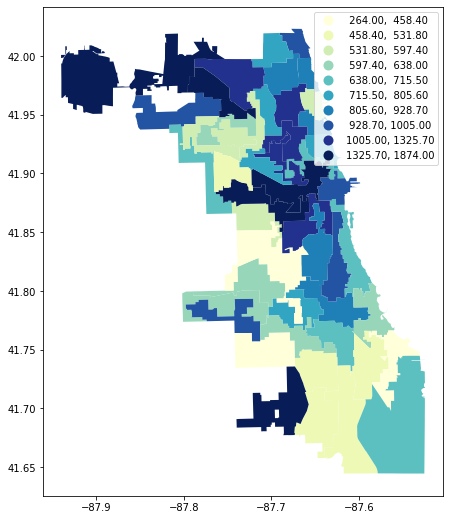

In [22]:
merged_gdf.plot(
    column='total',
    cmap='YlGnBu',
    figsize=(15,9),   
    scheme='quantiles',
    k=10,
    legend=True
)

In [23]:
merged_gdf.total.describe()

count      50.000000
mean      808.240000
std       349.623795
min       264.000000
25%       556.000000
50%       715.500000
75%       944.750000
max      1874.000000
Name: total, dtype: float64

In [24]:
merged_gdf.sort_values("total", ascending=False).head()[[
    'ward',
    'total'
]]

,ward,total
45,27,1874.0
28,41,1714.0
49,45,1497.0
22,28,1363.0
41,19,1332.0


In [25]:
merged_gdf.sort_values("total", ascending=False).tail()[[
    'ward',
    'total'
]]

,ward,total
0,12,453.0
29,18,416.0
36,7,414.0
2,15,390.0
27,22,264.0


Output wards totals

In [26]:
merged_gdf.to_file("./output/wards.geojson", driver="GeoJSON")

In [27]:
merged_gdf.drop(["geometry"], axis=1).sort_values("ward").to_csv("./output/wards.csv", index=False)

What regions got the most?

In [28]:
address_gdf = gpd.read_file("output/geocoding.geojson")

In [29]:
mapped_gdf = address_gdf.merge(
    df[~(df.source == 'parks')],
    left_on="address",
    right_on="address",
    how="inner"
)

In [30]:
mapped_gdf.to_file("./output/trees.geojson", driver="GeoJSON")

In [31]:
joined_gdf = gpd.sjoin(mapped_gdf, regions_gdf, how="left")

In [32]:
region_totals_df = joined_gdf.groupby("region").trees.sum().reset_index()

In [35]:
region_totals_df

,region,trees
0,Central,1944
1,Far South,3452
2,North,7135
3,Northwest,10045
4,South,3796
5,Southwest,5963
6,West,8020


In [36]:
region_totals_df.to_csv("./output/regions.csv", index=False)